In [1]:
# Install the Kaggle package
!pip install -q kaggle

# Create the Kaggle directory and move the kaggle.json API key there
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Set permissions for the Kaggle API key
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset from Kaggle
!kaggle datasets download ipythonx/mvtec-ad

# Unzip the dataset
!unzip mvtec-ad.zip -d mvtec-ad


Streaming output truncated to the last 5000 lines.
  inflating: mvtec-ad/carpet/train/good/149.png  
  inflating: mvtec-ad/carpet/train/good/150.png  
  inflating: mvtec-ad/carpet/train/good/151.png  
  inflating: mvtec-ad/carpet/train/good/152.png  
  inflating: mvtec-ad/carpet/train/good/153.png  
  inflating: mvtec-ad/carpet/train/good/154.png  
  inflating: mvtec-ad/carpet/train/good/155.png  
  inflating: mvtec-ad/carpet/train/good/156.png  
  inflating: mvtec-ad/carpet/train/good/157.png  
  inflating: mvtec-ad/carpet/train/good/158.png  
  inflating: mvtec-ad/carpet/train/good/159.png  
  inflating: mvtec-ad/carpet/train/good/160.png  
  inflating: mvtec-ad/carpet/train/good/161.png  
  inflating: mvtec-ad/carpet/train/good/162.png  
  inflating: mvtec-ad/carpet/train/good/163.png  
  inflating: mvtec-ad/carpet/train/good/164.png  
  inflating: mvtec-ad/carpet/train/good/165.png  
  inflating: mvtec-ad/carpet/train/good/166.png  
  inflating: mvtec-ad/carpet/train/good/167.png  

In [2]:
# Check the dataset structure
import os

dataset_path = "mvtec-ad"
for category in os.listdir(dataset_path):
    print(f"Category: {category}")
    category_path = os.path.join(dataset_path, category)
    if os.path.isdir(category_path):
        print(f" - Subfolders: {os.listdir(category_path)}")


Category: toothbrush
 - Subfolders: ['train', 'ground_truth', 'license.txt', 'readme.txt', 'test']
Category: leather
 - Subfolders: ['train', 'ground_truth', 'license.txt', 'readme.txt', 'test']
Category: bottle
 - Subfolders: ['train', 'ground_truth', 'license.txt', 'readme.txt', 'test']
Category: tile
 - Subfolders: ['train', 'ground_truth', 'license.txt', 'readme.txt', 'test']
Category: hazelnut
 - Subfolders: ['train', 'ground_truth', 'license.txt', 'readme.txt', 'test']
Category: grid
 - Subfolders: ['train', 'ground_truth', 'license.txt', 'readme.txt', 'test']
Category: screw
 - Subfolders: ['train', 'ground_truth', 'license.txt', 'readme.txt', 'test']
Category: zipper
 - Subfolders: ['train', 'ground_truth', 'license.txt', 'readme.txt', 'test']
Category: capsule
 - Subfolders: ['train', 'ground_truth', 'license.txt', 'readme.txt', 'test']
Category: license.txt
Category: carpet
 - Subfolders: ['train', 'ground_truth', 'license.txt', 'readme.txt', 'test']
Category: wood
 - Subfold

Training images:


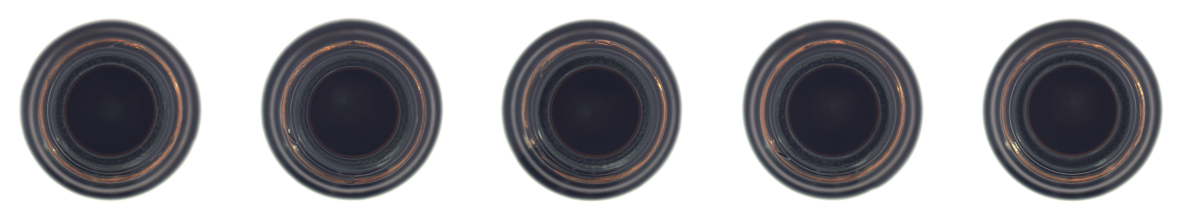

Testing images:


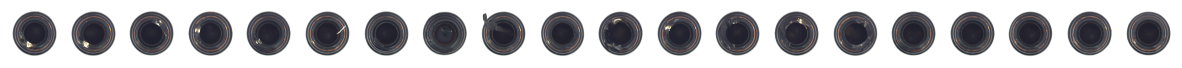

In [3]:
import cv2
import matplotlib.pyplot as plt

# Define paths for one category
category = "bottle"
train_path = os.path.join(dataset_path, category, "train")
test_path = os.path.join(dataset_path, category, "test")

# Function to load and display images
def display_images(path, n_images=5):
    images = []
    for root, _, files in os.walk(path):
        for file in files[:n_images]:  # Load only a few images for display
            if file.endswith(".png") or file.endswith(".jpg"):
                img_path = os.path.join(root, file)
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                images.append(img)
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for i, img in enumerate(images):
        axes[i].imshow(img)
        axes[i].axis("off")
    plt.show()

# Display training images
print("Training images:")
display_images(train_path)

# Display testing images
print("Testing images:")
display_images(test_path)


In [4]:
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Parameters for preprocessing
img_size = (224, 224)  # Resize all images to 224x224
batch_size = 32

# Function to preprocess a single image
def preprocess_image(img_path):
    img = load_img(img_path, target_size=img_size)
    img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
    return img_array

# Load all training images in a category
def load_images_from_folder(folder_path):
    images = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".png") or file.endswith(".jpg"):
                img_path = os.path.join(root, file)
                images.append(preprocess_image(img_path))
    return np.array(images)

# Preprocess training images for "bottle" category
train_images = load_images_from_folder(train_path)
print(f"Loaded {train_images.shape[0]} training images with shape {train_images.shape[1:]}")

# Repeat for other categories and test images as needed

Loaded 209 training images with shape (224, 224, 3)


In [5]:
from sklearn.model_selection import train_test_split

# Split the data (80% training, 20% validation)
train_images, val_images = train_test_split(train_images, test_size=0.2, random_state=42)

print(f"Training set size: {train_images.shape[0]}")
print(f"Validation set size: {val_images.shape[0]}")

Training set size: 167
Validation set size: 42


# autoencoder

In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D

# Define the autoencoder architecture
def build_autoencoder(input_shape):
    # Encoder
    input_img = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    # Compile the model
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

# Build the model
input_shape = (224, 224, 3)
autoencoder = build_autoencoder(input_shape)
autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 112, 112, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 224, 224, 3)         │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 75,651 (295.51 KB)

 Trainable params: 75,651 (295.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 15s 629ms/step - loss: 0.1144 - val_loss: 0.0917
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 0.0854 - val_loss: 0.0533
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0389 - val_loss: 0.0107
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0102 - val_loss: 0.0095
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0075 - val_loss: 0.0046
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0048 - val_loss: 0.0045
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0040 - val_loss: 0.0035
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0034 - val_loss: 0.0031
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0

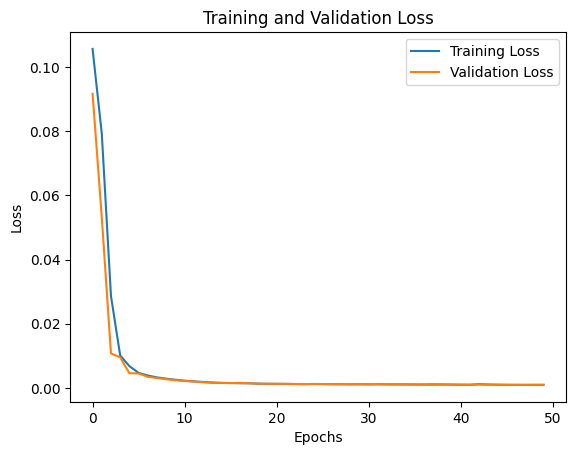

In [7]:
# Train the autoencoder
history = autoencoder.fit(
    train_images, train_images,  # Input and target are the same
    epochs=50,                  # Number of epochs
    batch_size=16,              # Batch size
    validation_data=(val_images, val_images),  # Validation data
    shuffle=True                # Shuffle the data
)

# Plot training history
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step


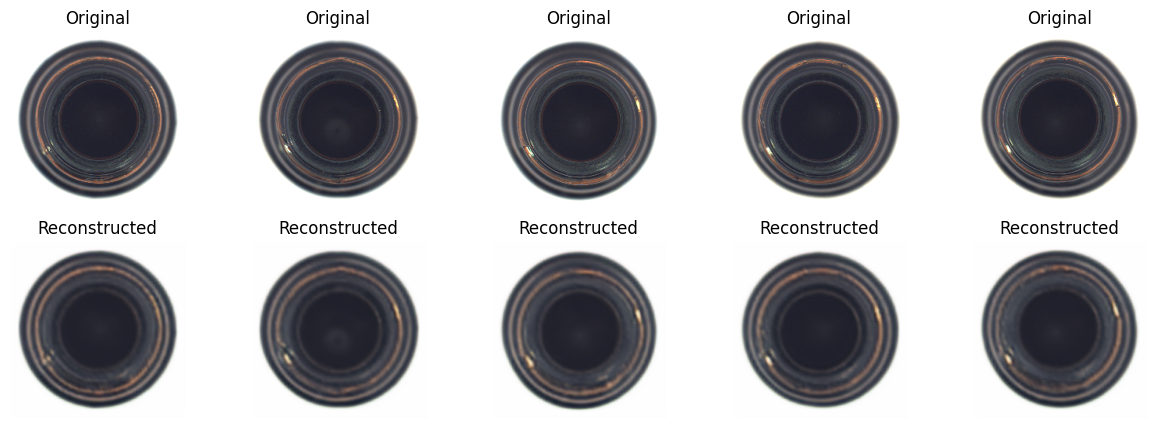

In [8]:
# Function to display original and reconstructed images
def display_reconstruction(model, images, n_images=5):
    reconstructed = model.predict(images[:n_images])  # Predict reconstructions
    fig, axes = plt.subplots(2, n_images, figsize=(15, 5))

    for i in range(n_images):
        # Original images
        axes[0, i].imshow(images[i])
        axes[0, i].set_title("Original")
        axes[0, i].axis("off")

        # Reconstructed images
        axes[1, i].imshow(reconstructed[i])
        axes[1, i].set_title("Reconstructed")
        axes[1, i].axis("off")

    plt.show()

# Visualize some images from the validation set
display_reconstruction(autoencoder, val_images)

In [9]:
import numpy as np

# Function to compute reconstruction error
def compute_reconstruction_error(model, images):
    reconstructed = model.predict(images)
    mse = np.mean(np.power(images - reconstructed, 2), axis=(1, 2, 3))
    return mse

# Compute reconstruction error on validation set
val_errors = compute_reconstruction_error(autoencoder, val_images)
print("Reconstruction error (validation set):")
print(val_errors[:10])  # Print first 10 errors


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 287ms/step
Reconstruction error (validation set):
[0.00102596 0.00085516 0.00119677 0.00084532 0.00109822 0.00095136
 0.00077908 0.00113639 0.0008999  0.00093453]


Loaded 83 test images.


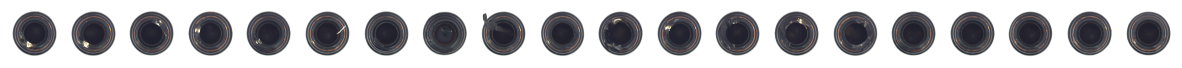

In [10]:
# Load and preprocess test images
def load_test_images(folder_path):
    return load_images_from_folder(folder_path)

# Load test images for the "bottle" category
test_path = os.path.join(dataset_path, "bottle", "test")
test_images = load_test_images(test_path)

# Display some test images
print(f"Loaded {test_images.shape[0]} test images.")
display_images(test_path, n_images=5)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step
Reconstruction error (test set):
[0.00122278 0.00117694 0.00117841 0.00132692 0.00093771 0.00095583
 0.00098511 0.00103081 0.00105811 0.00120081]


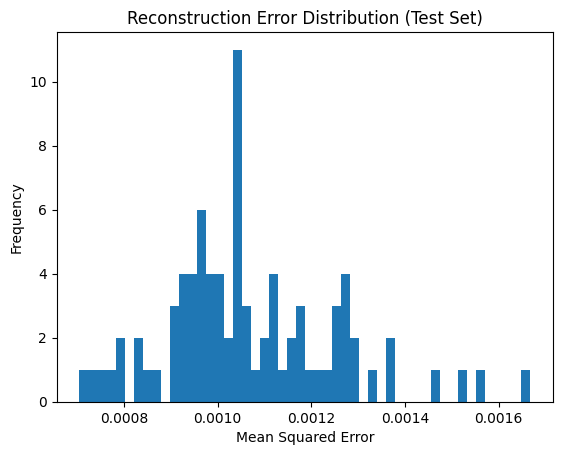

In [11]:
# Compute reconstruction error on test set
test_errors = compute_reconstruction_error(autoencoder, test_images)

# Visualize the errors (You can visualize based on index or categories)
print("Reconstruction error (test set):")
print(test_errors[:10])  # Print first 10 errors

# Optionally, plot a histogram to observe the error distribution
plt.hist(test_errors, bins=50)
plt.title("Reconstruction Error Distribution (Test Set)")
plt.xlabel("Mean Squared Error")
plt.ylabel("Frequency")
plt.show()

In [12]:
import os
import cv2
import numpy as np

# Function to generate ground truth labels based on subfolders
def generate_bottle_ground_truth_labels(ground_truth_base_path, total_images):
    labels = []

    # Define the subfolders with anomalies
    anomaly_subfolders = ['broken_large', 'broken_small', 'contamination']

    for i in range(total_images):
        label = 1  # Assume the bottle is normal (1) unless we find a damaged folder

        # Check the folder names for anomalies
        for subfolder in anomaly_subfolders:
            # Construct the path to the mask file
            mask_path = os.path.join(ground_truth_base_path, subfolder, f"{i:04d}_mask.png")

            # Check if the mask file exists in the subfolder
            if os.path.exists(mask_path):
                label = 0  # Anomaly detected, label as damaged
                break  # No need to check other subfolders once we find a damage indication

        labels.append(label)  # Append the label (0 or 1) for this image

    return labels

# Example usage
ground_truth_base_path = '/content/mvtec-ad/bottle/ground_truth'  # Base folder for the bottle ground truth
total_images = 63  # Total number of images for which you want to generate ground truth labels

# Ensure the directory exists
if not os.path.exists(ground_truth_base_path):
    print(f"Warning: The path {ground_truth_base_path} does not exist.")
else:
    ground_truth_labels = generate_bottle_ground_truth_labels(ground_truth_base_path, total_images)

    # Print out the ground truth labels for verification
    print(f"Generated Ground Truth Labels for {total_images} images:")
    print(ground_truth_labels)


Generated Ground Truth Labels for 63 images:
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [13]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model

def build_autoencoder(input_shape=(224, 224, 3)):
    # Encoder
    inputs = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(inputs, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return autoencoder


In [14]:
import os

def get_normal_image_paths_from_good_subfolder(train_folder_path):
    good_folder_path = os.path.join(train_folder_path, "good")
    normal_image_paths = []

    # Loop through the 'good' subfolder and collect image paths
    for img_file in os.listdir(good_folder_path):
        img_path = os.path.join(good_folder_path, img_file)
        if img_path.endswith(".png") or img_path.endswith(".jpg"):  # Assuming images are PNG or JPG
            normal_image_paths.append(img_path)

    return normal_image_paths

# Example usage
train_folder_path = '/content/mvtec-ad/bottle/train'
normal_image_paths = get_normal_image_paths_from_good_subfolder(train_folder_path)

print(f"Found {len(normal_image_paths)} normal images in the 'good' subfolder of 'train'.")


Found 209 normal images in the 'good' subfolder of 'train'.


In [15]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img

def preprocess_image(image_path, target_size=(224, 224)):
    # Load and resize the image
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array /= 255.0  # Normalize to [0, 1]
    return img_array

# Preprocess all normal images
train_images = [preprocess_image(img_path) for img_path in normal_image_paths]

# Convert to numpy array for model input
import numpy as np
train_images = np.array(train_images)

print(f"Processed {train_images.shape[0]} images with shape {train_images.shape[1:]}.")


Processed 209 images with shape (224, 224, 3).


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - loss: 0.6827 - val_loss: 0.6182
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - loss: 0.6166 - val_loss: 0.6004
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - loss: 0.5919 - val_loss: 0.5545
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - loss: 0.5397 - val_loss: 0.4918
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - loss: 0.4791 - val_loss: 0.4407
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - loss: 0.4283 - val_loss: 0.3920
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - loss: 0.3917 - val_loss: 0.3916
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - loss: 0.3874 - val_loss: 0.3811
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 0.3800 - val_loss: 0.3753
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - loss: 0.3741 - val_loss: 0.3683
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - loss: 0.3668 - val_loss: 0.3637
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - loss: 0.3629 - val_loss

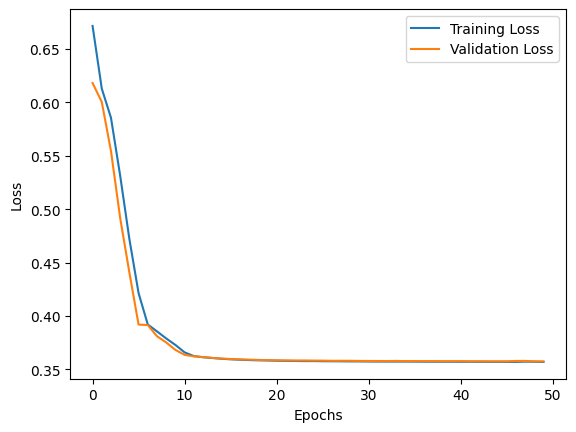

In [16]:
# Assuming the build_autoencoder function is already defined
autoencoder = build_autoencoder()

# Train the model on normal images (undamaged bottles) with validation split
history = autoencoder.fit(
    train_images, train_images,
    epochs=50,
    batch_size=32,
    validation_split=0.2  # Use 20% of the data for validation
)

# Plot training and validation loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Optionally save the model
autoencoder.save('bottle_autoencoder.h5')


In [17]:
import os

def get_test_image_paths_and_labels(test_folder_path):
    image_paths = []
    labels = []

    # Loop through subfolders in 'test' directory
    for subfolder in os.listdir(test_folder_path):
        subfolder_path = os.path.join(test_folder_path, subfolder)

        if os.path.isdir(subfolder_path):
            for img_file in os.listdir(subfolder_path):
                img_path = os.path.join(subfolder_path, img_file)
                if img_path.endswith(".png") or img_path.endswith(".jpg"):  # Assuming images are PNG or JPG
                    image_paths.append(img_path)
                    # Label: 0 for good, 1 for anomaly (based on subfolder name)
                    if subfolder == "good":
                        labels.append(0)  # Normal
                    else:
                        labels.append(1)  # Anomalous

    return image_paths, labels

# Example usage
test_folder_path = '/content/mvtec-ad/bottle/test'
test_image_paths, ground_truth_labels = get_test_image_paths_and_labels(test_folder_path)

print(f"Found {len(test_image_paths)} test images with labels.")


Found 83 test images with labels.


In [18]:
# Preprocess the test images (same way we did for training)
test_images = [preprocess_image(img_path) for img_path in test_image_paths]
test_images = np.array(test_images)

print(f"Processed {test_images.shape[0]} test images with shape {test_images.shape[1:]}.")


Processed 83 test images with shape (224, 224, 3).


In [19]:
# Reconstruct the test images using the trained autoencoder
reconstructed_images = autoencoder.predict(test_images)

# Calculate the reconstruction error (Mean Squared Error)
reconstruction_errors = np.mean(np.square(test_images - reconstructed_images), axis=(1, 2, 3))

# Set a threshold for anomaly detection (e.g., using the 95th percentile of the reconstruction error)
threshold = np.percentile(reconstruction_errors, 95)
print(f"Anomaly detection threshold: {threshold}")

# Classify anomalies based on the threshold
predicted_anomalies = reconstruction_errors > threshold


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 814ms/step
Anomaly detection threshold: 0.0016176560660824176


In [22]:
import matplotlib.pyplot as plt

def display_anomalies(images, errors, predicted_anomalies, n_images=5):
    """
    Displays a specified number of anomalous images with their reconstruction error.

    Parameters:
    - images: np.array, original test images.
    - errors: np.array, reconstruction errors.
    - predicted_anomalies: np.array, boolean array of anomalies detected.
    - n_images: int, number of anomalous images to display.
    """
    anomaly_indices = np.where(predicted_anomalies)[0]  # Indices of anomalies
    if len(anomaly_indices) == 0:
        print("No anomalies detected.")
        return

    n_display = min(n_images, len(anomaly_indices))
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(anomaly_indices[:n_display]):
        plt.subplot(1, n_display, i + 1)
        plt.imshow(images[idx])
        plt.title(f"Error: {errors[idx]:.4f}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()


Loaded 83 test images from all subfolders.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Anomaly detection threshold: 0.0016176560660824176
Precision: 1.0000
Recall: 0.0794
F1-Score: 0.1471


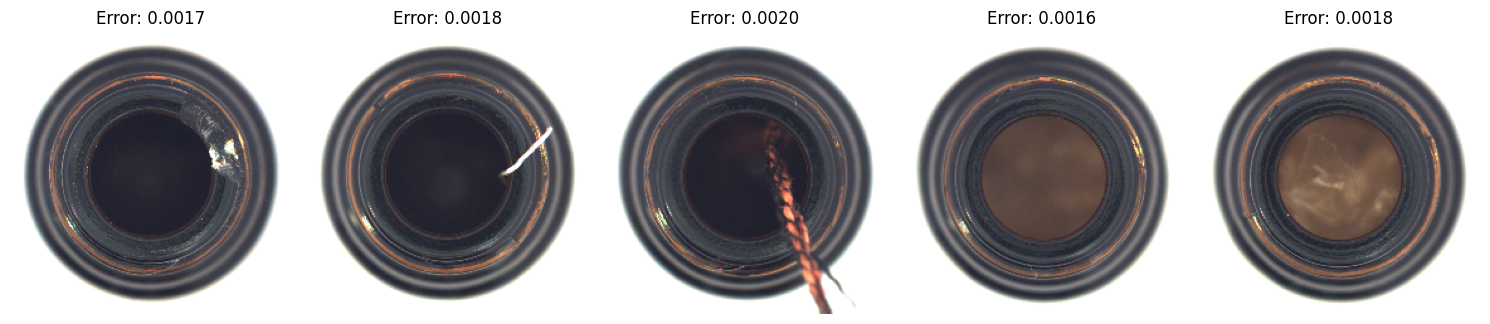

In [23]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Function to load all test images from all subfolders (including good and anomalous)
def load_all_test_images(test_folder_path, target_size=(224, 224)):
    image_paths = []
    labels = []

    # Loop through all subfolders in the 'test' directory
    for subfolder in os.listdir(test_folder_path):
        subfolder_path = os.path.join(test_folder_path, subfolder)

        if os.path.isdir(subfolder_path):  # Check if it is a folder
            for img_file in os.listdir(subfolder_path):
                img_path = os.path.join(subfolder_path, img_file)
                if img_path.endswith(".png") or img_path.endswith(".jpg"):  # Assuming images are PNG or JPG
                    image_paths.append(img_path)
                    # Label: 0 for good, 1 for anomaly (based on subfolder name)
                    if subfolder == "good":
                        labels.append(0)  # Normal
                    else:
                        labels.append(1)  # Anomalous

    # Preprocess all images
    images = [preprocess_image(img_path, target_size) for img_path in image_paths]
    images = np.array(images)
    return images, np.array(labels)

# Function to preprocess the image
def preprocess_image(image_path, target_size=(224, 224)):
    # Load and resize the image
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array /= 255.0  # Normalize to [0, 1]
    return img_array

# Example usage
test_folder_path = '/content/mvtec-ad/bottle/test'  # Update path to your test folder
test_images, ground_truth_labels = load_all_test_images(test_folder_path)

print(f"Loaded {test_images.shape[0]} test images from all subfolders.")

# Now you can predict anomalies using the trained autoencoder
reconstructed_images = autoencoder.predict(test_images)

# Calculate the reconstruction error (Mean Squared Error)
reconstruction_errors = np.mean(np.square(test_images - reconstructed_images), axis=(1, 2, 3))

# Set a threshold for anomaly detection (e.g., using the 95th percentile of the reconstruction error)
threshold = np.percentile(reconstruction_errors, 95)
print(f"Anomaly detection threshold: {threshold}")

# Classify anomalies based on the threshold
predicted_anomalies = reconstruction_errors > threshold

# Optionally: Print out Precision, Recall, F1-Score (based on predicted anomalies vs. ground truth labels)
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(ground_truth_labels, predicted_anomalies)
recall = recall_score(ground_truth_labels, predicted_anomalies)
f1 = f1_score(ground_truth_labels, predicted_anomalies)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Display the first few anomalies (you can adjust the number as needed)
display_anomalies(test_images, reconstruction_errors, predicted_anomalies, n_images=5)


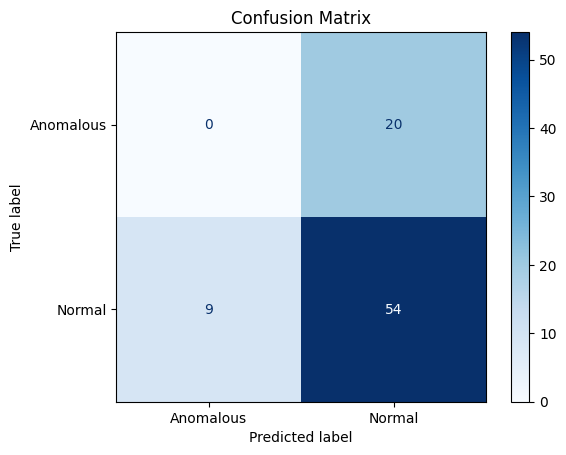

Accuracy: 0.65

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.73      0.86      0.79        63

    accuracy                           0.65        83
   macro avg       0.36      0.43      0.39        83
weighted avg       0.55      0.65      0.60        83



In [24]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Define threshold for anomaly detection based on reconstruction error
def calculate_predicted_labels(reconstruction_errors, threshold):
    return np.array([1 if err < threshold else 0 for err in reconstruction_errors])

# Calculate evaluation metrics and display confusion matrix
def evaluate_and_display_metrics(ground_truth_labels, predicted_labels):
    # Compute confusion matrix
    cm = confusion_matrix(ground_truth_labels, predicted_labels)
    accuracy = accuracy_score(ground_truth_labels, predicted_labels)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Anomalous", "Normal"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

    # Print accuracy and detailed classification report
    print(f"Accuracy: {accuracy:.2f}")
    print("\nClassification Report:")
    print(classification_report(ground_truth_labels, predicted_labels))

# Assuming we have the following variables from earlier steps:
# - ground_truth_labels: The true labels (e.g., [1, 1, 0, 0, 1])
# - test_errors: The reconstruction errors for the test images (computed earlier)

# Example: Calculate threshold (use a predefined value or based on data analysis)
threshold = np.percentile(test_errors, 90)  # E.g., top 10% errors are anomalies

# Calculate predicted labels
predicted_labels = calculate_predicted_labels(test_errors, threshold)

# Evaluate and display metrics
evaluate_and_display_metrics(ground_truth_labels, predicted_labels)

# CNN Autoencoder

In [25]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D

def build_cnn_autoencoder(input_shape=(224, 224, 3)):
    # Encoder
    input_img = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    # Autoencoder model
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

# Build the model
cnn_autoencoder = build_cnn_autoencoder()
cnn_autoencoder.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 28, 28, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_4 (UpSampling2D)       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 56, 56, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_5 (UpSampling2D)       │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 112, 112, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_6 (UpSampling2D)       │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 224, 224, 3)         │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 333,955 (1.27 MB)

 Trainable params: 333,955 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# Train the CNN autoencoder
history = cnn_autoencoder.fit(
    train_images,  # Training data
    train_images,  # Target data (same as input for autoencoder)
    epochs=50,     # Number of epochs
    batch_size=32, # Batch size
    validation_data=(val_images, val_images)  # Validation data
)


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - loss: 0.1188 - val_loss: 0.0949
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - loss: 0.0865 - val_loss: 0.0540
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - loss: 0.0535 - val_loss: 0.0447
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 0.0373 - val_loss: 0.0184
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - loss: 0.0172 - val_loss: 0.0128
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - loss: 0.0111 - val_loss: 0.0072
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - loss: 0.0066 - val_loss: 0.0048
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - loss: 0.0045 - val_loss: 0.0041
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - loss: 0.0031 - val_loss

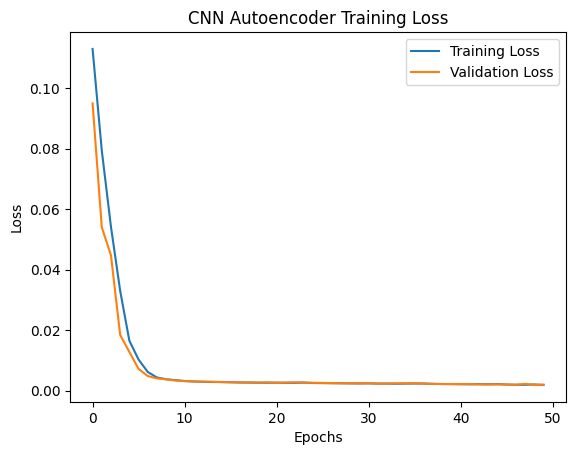

In [27]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# Adding labels and title
plt.title('CNN Autoencoder Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Display the plot
plt.show()

In [28]:
# Compute the reconstruction error (Mean Squared Error)
reconstruction_errors = np.mean(np.square(test_images - reconstructed_images), axis=(1, 2, 3))

# Set a threshold for anomaly detection (e.g., using the 95th percentile of the reconstruction error)
threshold = np.percentile(reconstruction_errors, 95)
print(f"Anomaly detection threshold: {threshold}")

# Classify anomalies based on the threshold
predicted_anomalies = reconstruction_errors > threshold


Anomaly detection threshold: 0.0016176560660824176


In [29]:
# Classify anomalies based on reconstruction errors exceeding the threshold
predicted_anomalies = reconstruction_errors > threshold

In [30]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Calculate Precision, Recall, F1-Score, and Accuracy
precision = precision_score(ground_truth_labels, predicted_anomalies)
recall = recall_score(ground_truth_labels, predicted_anomalies)
f1 = f1_score(ground_truth_labels, predicted_anomalies)
accuracy = accuracy_score(ground_truth_labels, predicted_anomalies)

# Print all metrics
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")


Precision: 1.0000
Recall: 0.0794
F1-Score: 0.1471
Accuracy: 0.3012


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Anomaly detection threshold: 0.0016176560660824176


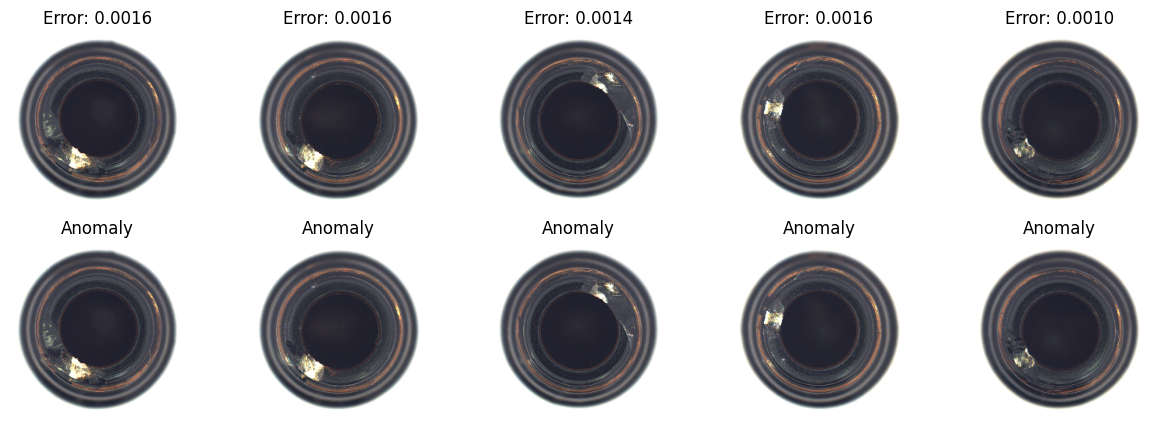

In [31]:
def display_anomalies(images, errors, predictions, n_images=5):
    fig, axes = plt.subplots(2, n_images, figsize=(15, 5))

    for i in range(n_images):
        # Original images
        axes[0, i].imshow(images[i])
        axes[0, i].set_title(f"Error: {errors[i]:.4f}")
        axes[0, i].axis("off")

        # Reconstructed images
        axes[1, i].imshow(images[i])  # Use the original image for simplicity here
        axes[1, i].set_title(f"Anomaly")
        axes[1, i].axis("off")# Now you can predict anomalies using the trained autoencoder
reconstructed_images = autoencoder.predict(test_images)

# Calculate the reconstruction error (Mean Squared Error)
reconstruction_errors = np.mean(np.square(test_images - reconstructed_images), axis=(1, 2, 3))

# Set a threshold for anomaly detection (e.g., using the 95th percentile of the reconstruction error)
threshold = np.percentile(reconstruction_errors, 95)
print(f"Anomaly detection threshold: {threshold}")

# Classify anomalies based on the threshold
predicted_anomalies = reconstruction_errors > threshold

# Display the first few anomalies (you can adjust the number as needed)
display_anomalies(test_images, reconstruction_errors, predicted_anomalies, n_images=5)


In [32]:
# Count total anomalies detected
total_anomalies = np.sum(predicted_anomalies)

print(f"Total anomalies detected: {total_anomalies}")


Total anomalies detected: 5


Confusion Matrix:
[[20  0]
 [58  5]]


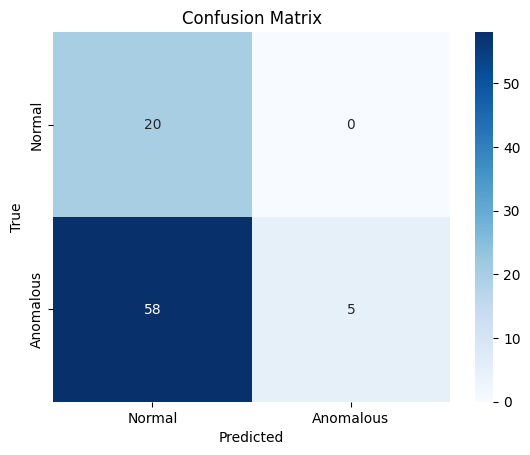

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate confusion matrix
cm = confusion_matrix(ground_truth_labels, predicted_anomalies)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Optionally: Plot confusion matrix using seaborn heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomalous'], yticklabels=['Normal', 'Anomalous'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# Variational Autoencoder

In [34]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras import backend as K

class VAE(Model):
    def __init__(self, original_dim, latent_dim):
        super(VAE, self).__init__()
        self.original_dim = original_dim
        self.latent_dim = latent_dim

        # Encoder part
        self.encoder = tf.keras.Sequential([
            layers.InputLayer(input_shape=original_dim),
            layers.Conv2D(32, (3, 3), activation='relu', strides=2, padding='same'),
            layers.Conv2D(64, (3, 3), activation='relu', strides=2, padding='same'),
            layers.Conv2D(128, (3, 3), activation='relu', strides=2, padding='same'),
            layers.Flatten(),
            layers.Dense(latent_dim + latent_dim)  # Mean and log_variance
        ])

        # Decoder part (adjust to output the correct size)
        self.decoder = tf.keras.Sequential([
            layers.InputLayer(input_shape=(latent_dim,)),
            layers.Dense(28 * 28 * 128, activation='relu'),
            layers.Reshape((28, 28, 128)),
            layers.Conv2DTranspose(128, (3, 3), activation='relu', strides=2, padding='same'),
            layers.Conv2DTranspose(64, (3, 3), activation='relu', strides=2, padding='same'),
            layers.Conv2DTranspose(32, (3, 3), activation='relu', strides=2, padding='same'),
            layers.Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')
        ])

    def call(self, inputs):
        z_mean, z_log_var, z = self.encode(inputs)
        reconstructed = self.decode(z)
        kl_loss = -0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        self.add_loss(K.mean(kl_loss))
        return reconstructed

    def encode(self, x):
        # Encode the input into a latent vector (z)
        h = self.encoder(x)
        z_mean = h[:, :self.latent_dim]
        z_log_var = h[:, self.latent_dim:]
        z = z_mean + K.exp(0.5 * z_log_var) * K.random_normal(K.shape(z_mean))
        return z_mean, z_log_var, z

    def decode(self, z):
        # Decode the latent vector back to the original shape (224, 224, 3)
        return self.decoder(z)


In [35]:
# Prepare training data (normal images)
normal_images = np.array(train_images)  # Assuming `train_images` contains the normal images

# Build and compile the VAE
vae = VAE(original_dim=(224, 224, 3), latent_dim=2)
vae.compile(optimizer='adam', loss='binary_crossentropy')

# Train the VAE model
history = vae.fit(normal_images, normal_images, epochs=50, batch_size=32, validation_split=0.1)



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - loss: 3.1359 - val_loss: 0.7490
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 0.7268 - val_loss: 0.6976
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 0.6956 - val_loss: 0.6826
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 0.6728 - val_loss: 0.6183
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 0.5883 - val_loss: 0.4922
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 0.4805 - val_loss: 0.4565
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 0.4527 - val_loss: 0.4455
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 0.4434 - val_loss: 0.4310
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 0.4229 - val_loss: 0.3929
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 0.3873 - val_loss: 0.3879
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - loss: 0.3821 - val_loss: 0.3707
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 0.3704 - val_loss: 0.3699


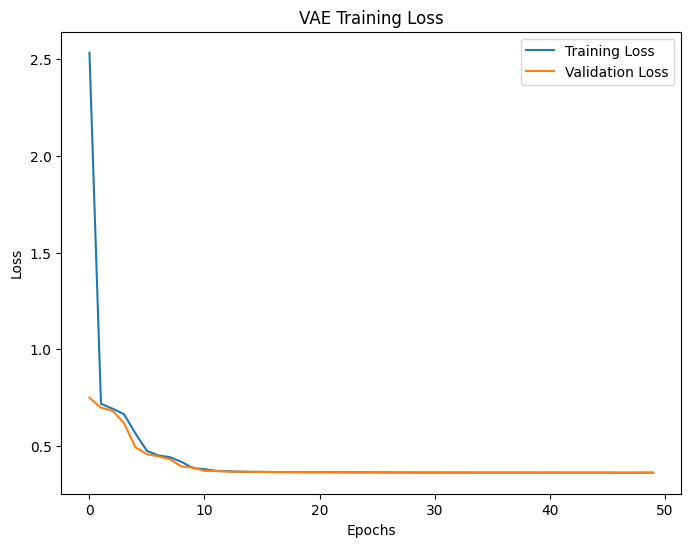

In [36]:
import matplotlib.pyplot as plt

# Plot the training loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')

# Check if 'val_loss' is available
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('VAE Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [37]:
# Predict the reconstruction of test images
reconstructed_images = vae.predict(test_images)

# Calculate the reconstruction error (Mean Squared Error)
reconstruction_errors = np.mean(np.square(test_images - reconstructed_images), axis=(1, 2, 3))

# Set a threshold for anomaly detection (e.g., using the 95th percentile of the reconstruction error)
threshold = np.percentile(reconstruction_errors, 95)
print(f"Anomaly detection threshold: {threshold}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step
Anomaly detection threshold: 0.007398508349433537


In [38]:
# Classify anomalies based on the threshold
predicted_anomalies = reconstruction_errors > threshold

In [39]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Compute the metrics
precision = precision_score(ground_truth_labels, predicted_anomalies)
recall = recall_score(ground_truth_labels, predicted_anomalies)
f1 = f1_score(ground_truth_labels, predicted_anomalies)
accuracy = accuracy_score(ground_truth_labels, predicted_anomalies)

# Print all metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.3012
Precision: 1.0000
Recall: 0.0794
F1-Score: 0.1471


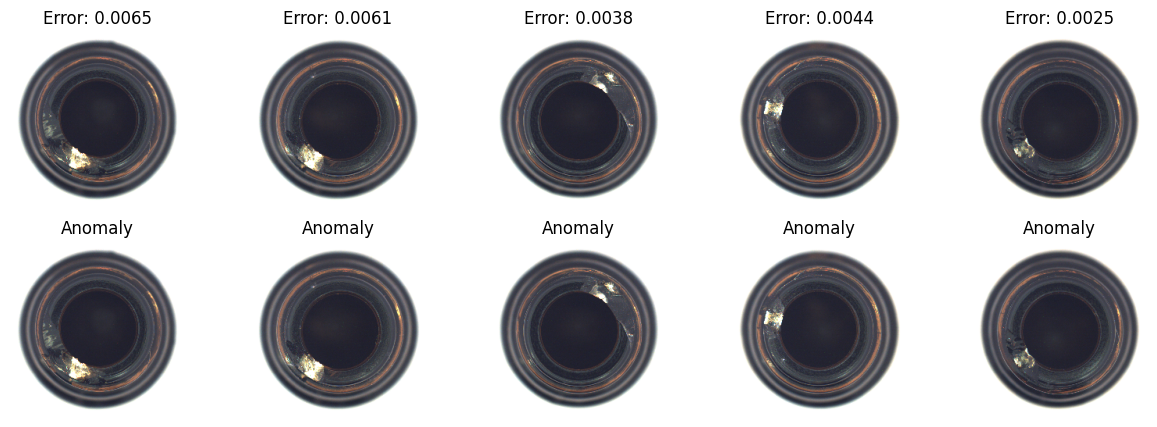

In [40]:
# Function to display anomalies
def display_anomalies(images, errors, predictions, n_images=5):
    fig, axes = plt.subplots(2, n_images, figsize=(15, 5))

    for i in range(n_images):
        # Original images
        axes[0, i].imshow(images[i])
        axes[1, i].imshow(images[i])  # Use the original image for simplicity here
        axes[0, i].set_title(f"Error: {errors[i]:.4f}")
        axes[0, i].axis("off")

        # Reconstructed images

        axes[1, i].set_title(f"Anomaly")
        axes[1, i].axis("off")

    plt.show()

# Display some anomalies
display_anomalies(test_images, reconstruction_errors, predicted_anomalies, n_images=5)


In [41]:
# Print total number of anomalies detected
total_anomalies = np.sum(predicted_anomalies)
print(f"Total anomalies detected: {total_anomalies}/{len(test_images)}")


Total anomalies detected: 5/83


Confusion Matrix:
[[20  0]
 [58  5]]


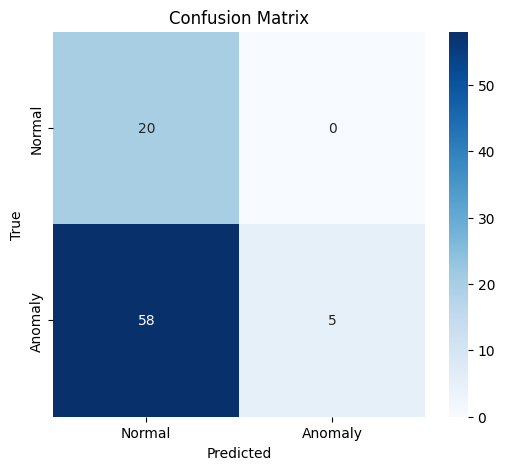

In [42]:
# Compute confusion matrix
cm = confusion_matrix(ground_truth_labels, predicted_anomalies)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)
# Plot confusion matrix using Seaborn heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Anomaly"], yticklabels=["Normal", "Anomaly"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
